# Sympy & Risk Computation at Counsyl

<b>Lucas Wiman</b>

2018-02-15


## Thanks
- Risk code has many clever ideas, none original to me.
- Many thanks to:
  - @ksarn for writing the BTD risk computation & answering my many questions about it.
  - @dan for helping me understand the risk code when I was deleriously tired.

## Background
- Our risk code is complicated.
- I had a lot of trouble understanding it.
- I explored Sympy as a way of helping explain it.
- It worked (kinda).
- Anyway, Sympy is a useful tool you should know about if you do scientific computation.

## Sympy

* Symbolic algebra package for python
* Similar idea to Mathematica, though less powerful.
* But it's in _python_, which makes it more useful.
  * `pip install sympy`

## Key features (opinionated)

* Basic algebra
* Basic calculus
* LaTeX math formatting
* Plotting

In [2]:
from sympy import *
import sympy
# Sets up LaTeX output in jupyter notebook:
init_printing()

# Shows plots in jupyter notebook:
%matplotlib inline
from matplotlib import pyplot as plt

x, y, z, n, m, k, i, j = symbols('x, y, z, n, m, k, i, j')
t = Symbol('t')

## "I hate math"

* Think back to calculus
* It was boring and repetitive

* Computers _kill it_ at boring and repetitive

## Example: MacLaurin expansion

Approximate some function with a polynomial:

$$ f(x) = \sum_{n=0}^\infty \frac{f^{(n)}(0)}{n!}x^n $$

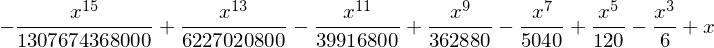

In [4]:
def maclaurin(expression, symbol, n):
    """
    Generate the nth MacLaurin polynomial for the
    given ``expression`` with respect to ``symbol``.
    """
    return expression.subs({symbol: 0}) + sum(
        diff(expression, symbol, i).subs({symbol: 0}) / factorial(i) * (symbol ** i)
        for i in range(1, n+1)
    )

maclaurin(sin(x), x, 15)

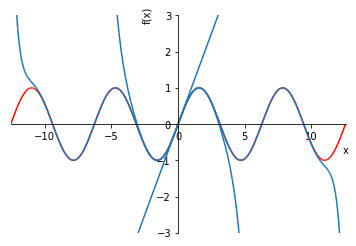

In [5]:
p = plot(sin(x),
         maclaurin(sin(x), x, 1),
         maclaurin(sin(x), x, 7),
         maclaurin(sin(x), x, 27),
         (x, -4 * pi, 4 * pi), ylim=(-3, 3), show=False)
p[0].line_color = 'red'
p.show()

## Example: debugging

![image.png](./debugging.png)

## Many hours lost
![image.png](./hours-lost.png)

## Much easier if you can see what the code is doing:
```python
from counsyl.product.science_genomics.models import *
from sympy import *
child = Child.objects.get(owner__orderkit__sample__barcode=barcode)
[disease] = [d for d in Disease.objects.all() if d.is_g6pd]
risk, namespace = get_symbolic_risk_and_namespace(child, disease)
print('Reproductive risk is: %s' % risk.affected.subs(namespace))
print(latex(risk.affected))
print(namespace)
print(latex(simplify(risk.affected)))
```

### Output

```
Reproductive risk is: 0.289473684210526
{F_{\textrm{SAS}}: 0.1, d_{\textrm{SAS}}: 0.5}
```
$$ \frac{F_{\textrm{SAS}}^{2} d_{\textrm{SAS}} \left(- d_{\textrm{SAS}} + 1\right)}{2 F_{\textrm{SAS}}^{2} d_{\textrm{SAS}} \left(- d_{\textrm{SAS}} + 1\right) + 2 F_{\textrm{SAS}} d_{\textrm{SAS}} \left(- F_{\textrm{SAS}} + 1\right)} + \frac{0.5 F_{\textrm{SAS}} d_{\textrm{SAS}} \left(- F_{\textrm{SAS}} + 1\right)}{2 F_{\textrm{SAS}}^{2} d_{\textrm{SAS}} \left(- d_{\textrm{SAS}} + 1\right) + 2 F_{\textrm{SAS}} d_{\textrm{SAS}} \left(- F_{\textrm{SAS}} + 1\right)} + \frac{F_{\textrm{SAS}}}{2} \left(\frac{2 F_{\textrm{SAS}}^{2} d_{\textrm{SAS}} \left(- d_{\textrm{SAS}} + 1\right)}{2 F_{\textrm{SAS}}^{2} d_{\textrm{SAS}} \left(- d_{\textrm{SAS}} + 1\right) + 2 F_{\textrm{SAS}} d_{\textrm{SAS}} \left(- F_{\textrm{SAS}} + 1\right)} + \frac{1.0 F_{\textrm{SAS}} d_{\textrm{SAS}} \left(- F_{\textrm{SAS}} + 1\right)}{2 F_{\textrm{SAS}}^{2} d_{\textrm{SAS}} \left(- d_{\textrm{SAS}} + 1\right) + 2 F_{\textrm{SAS}} d_{\textrm{SAS}} \left(- F_{\textrm{SAS}} + 1\right)}\right) $$
<hr>
$$ \frac{0.25}{F_{\textrm{SAS}} d_{\textrm{SAS}} - 1} \left(2.0 F_{\textrm{SAS}}^{2} d_{\textrm{SAS}} - 1.0 F_{\textrm{SAS}}^{2} + 2.0 F_{\textrm{SAS}} d_{\textrm{SAS}} - 2.0 F_{\textrm{SAS}} - 1.0\right) $$

Here $F_{\textrm{SAS}}$ is the deleterious allele frequency for G6PD among South Asians and $d_{\textrm{SAS}}$ is the detection rate among South Asians.

## BTD Risk

* BTD has complex genetics.
  * D444H is a "partial deficiency" allele. It does not cause disease even when it's homozygous.
  * _But_ there are some mutations that have accumulated on the same haplotype which are deleterious.
* The risk computation is fairly simple, but the devil is in the details.
* Someone is affected with BTD if:
  1. They have D444H and some deleterious allele.
  2. Unless that allele is one of A171T or F403V, in which case we assume only one copy of the gene is nonfunctional.
  3. They have two deleterious alleles.

## BTD Risk
* Usually the allele distribution has two elements: deleterious or not.
* With BTD, it has 9 elements:
  1. D444H
  2. D444H in cis with F403V
  3. D444H in cis with A171T
  4. D444H in cis with some other pathogenic variant. (assumed kinda rare)
  5. Some other pathogenic variant.
  6. A171T alone, which happened one time and broke stuff. (assumed very rare)
  7. No deleterious mutations.
  8. D444H in cis with both F403V and an other pathogenic variant. (assumed very rare)
  9. D444H in cis with both A171T and an other pathogenic variant. (assumed very rare)

## This is too complicated for a GC to do while counseling a patient:
![image.png](./too-complicated.png)

### GC's want a big lookup table for all possible (test result, ethnicity pairs).
* 11 ethnicities, 43 scenarios, so $11^2\cdot 43 = 5,203$ cells in this lookup table.
* For a couple, the code forms a probability distribution with $9^4=6,561$ elements, then applies a Bayesian update based on the interpretation of the calls and our detection rate.
* The risk code is kinda slow at this.
* Initial prototype: ~1hr to run to completion, improved it with ordinary profiling / ORM fixes.


###  Idea

Run the computation symbolically, then just substitute in the numbers for all the different ethnicities:
![image.png](./sympy-speedup.png)

## `lambidfy`

Sympy lets you compile expressions into lambdas that it can then run pretty quickly.

## `lambdify`
Simplified example:
```python
In [5]: expr = x**2 + x + 1
   ...: namespace = {x: 1}
   ...: %timeit expr.subs(namespace)
The slowest run took 17.77 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 84.3 µs per loop
In [6]: lambdified = lambdify([x], expr)
   ...: %timeit lambdified(1)
   ...: 
10000000 loops, best of 3: 201 ns per loop
```

# How we compute pre- and post-test risk

- This covers Foresight tests.
- There are presumably differences for Reliant, and certainly for Prelude.

## Standard Mendelian Inheritance

- We assume there are two kinds of haplotypes:
    - Ones which contain one or more deleterious mutation (autosomal recessive, written a)
    - Ones which contain no deleterious mutations (autosomal dominant, written A)
- If we detect 1 mutation: patient is a carrier.
- If we detect 2 or more mutations: patient is affected.

## Punnett Square - two heterozygotes
<table>
    <tr>
        <td></td>
        <th>a</th>
        <th>A</th>
    </tr>
    <tr>
        <th>a</th>
        <td style="color: green;">aa</td>
        <td style="color: blue; font-weight: bold;">aA</td>
    </tr>
    <tr>
        <th>A</th>
        <td style="color: blue; font-weight: bold;">Aa</td>
        <td><b style="color: red">AA</b></td>
    </tr>
</table>

Let $q$ denote the freqency of a, $p=1-q$ denote the frequency of A in the population. We have a _discrete probability distribution_ given by the table:
<table>
    <tr>
        <th>$P(A)$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</th>
        <td>$p$</td>
    </tr>
    <tr>
        <th>$P(a)$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</th>
        <td>$q$</td>
    </tr>
</table>

In [155]:
from counsyl.product.risk.calculation.transmission_scenarios.single_locus import AlleleProbability, GenotypeProbability
q = Symbol('q')
allele_prior = AlleleProbability({0: 1-q, 1: q})
allele_prior

0    -q + 1
1         q
dtype: object

Now we assume the two (diploid) alleles in an individual are drawn from independently, giving us the genotype prior as a product distribution:

In [154]:
from counsyl.product.risk.calculation.math import get_product_distribution
from counsyl.product.risk.constants import *
from counsyl.product.risk.report import *
product_distribution = get_product_distribution(allele_prior, allele_prior)
product_distribution

0  0    (-q + 1)**2
   1     q*(-q + 1)
1  0     q*(-q + 1)
   1           q**2
dtype: object

In [153]:
genotype_prior = GenotypeProbability(
    get_product_distribution(allele_prior, allele_prior)

    # Sum the number of deleterious alleles.
    .transform(sum)
    
    # Map counts to constants ued in computing risk.
    .transform({0: ZERO, 1: ONE, 2: TWO_PLUS}))
genotype_prior

0      (-q + 1)**2
1     2*q*(-q + 1)
2+            q**2
dtype: object

Recall that someone was _affected_ by the disease if and only if they have genotype "2+". In the `risk` code, this is called a `PhenotypeProbability`:

In [156]:
phenotype_prior = genotype_prior.get_phenotype_probability(inheritance_pattern='AR', sex=FEMALE)
phenotype_prior

affected              q**2
carrier       2*q*(-q + 1)
unaffected     (-q + 1)**2
dtype: object

## Getting to numbers

- We don't know the distribution of deleterious alleles a priori.
- We do have disease prevalence numbers.
- And we have an algebraic expression for prevalence in terms of the allele frequency:
$$\textrm{prevalence} = q^2$$

OK, that's pretty easy to solve, but let's use Sympy anyway, for kicks:

In [77]:
from sympy import solveset, S, assuming, Q, Eq
prevalence = Symbol('prevalence')
prevalence_equation = Eq(prevalence, phenotype_prior['affected'])
prevalence_equation

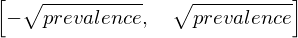

In [78]:
solve(prevalence_equation, q)

One of these solutions makes no sense: probabilities can't be negative! How do we get sympy to see this

In [83]:
q, prevalence = symbols('q, prevalence', positive=True)

In [88]:
[solution] = solve(Eq(q ** 2, prevalence), q)
solution

In [89]:
solution.subs({prevalence: 1./5000})

## "Harder" example

That's pretty easy in this case, but we use the same idea in NPHS2:

In [85]:
from counsyl.product.risk.calculation.transmission_scenarios import nphs2
nphs2.get_prevalence_equation()

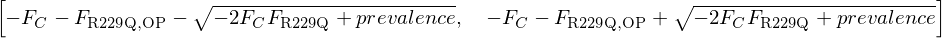

In [86]:
solve(nphs2.get_prevalence_equation(), nphs2.OTHER_PATHOGENIC.get_symbol())

This is actually just the quadratic formula you learned in high school, but with less tedium and algebraic manipulation.

## Post-test risk: Detection Rate

The detection rate is the probability of observing a deleterious variant _given that it is present_. In symbols:
$$
P(\textrm{observed}\ |\ \textrm{present})
$$

## Detection Rate: Fun facts

- This is the _analytical_ detection rate. For the purposes of reported risk nubmers, we ignore how likely we are to successfully classify a VUS as deleterious.
- We never use a detection rate >99%.
- For sequencing, the detection rate is computed as:

\begin{align}
           \textrm{detection rate} &= 1 - P(\textrm{undetected}\ |\ \textrm{present}) \\
P(\textrm{undetected}\ |\ \textrm{present}) &= (\textrm{del rate})(1 - \textrm{del sensitivity}) \\
                                   & \quad + (\textrm{dup rate})(1-\textrm{dup sensitivity}) \\
                                   & \quad + (\textrm{other structural variant rate})(1 - \textrm{other struct sensitivity}) \\
\end{align}

## Residual Carrier Risk

We want to know how likely it is that we missed a deleterious mutation that is present. We want to know:
$$
P(\textrm{genotype}\in \{aa, aA\})\ |\ AA\ \textrm{observed})
$$ 

## Example

- We did not detect any deleterious mutations in a patient.
- Disease prevalence of 1/10,000.
- Detection rate 99%.

## Bae's theorem 
$$
P(\textrm{chill}\ |\ \textrm{netflix}) = \frac{P(\textrm{netflix}\ |\ \textrm{chill})P(\textrm{chill})}{P(\textrm{netflix})}
$$
(h/t @alittlestats https://twitter.com/alittlestats/status/664923862853922820)

## Bayes' theorem 
$$
P(A\ |\ B) = \frac{P(B\ |\ A)P(A)}{P(B)}
$$
(h/t @alittlestats https://twitter.com/alittlestats/status/664923862853922820)

## We know enough probabilities to use Bayes' theorem:
\begin{align}
P(\textrm{genotype}\in \{aa, aA\})\ |\ AA\ \textrm{observed}) &= P(\textrm{genotype}=aa)\ |\ AA\ \textrm{observed}) + P(\textrm{genotype}=Aa\ |\ AA\ \textrm{observed}) \\
P(\textrm{genotype}=Aa\ |\ AA\ \textrm{observed}) &= \frac{P(AA\ \textrm{observed}\ |\ \textrm{genotype}=Aa)P(\textrm{genotype}=Aa)}{P(AA\ \textrm{observed})} \\
P(AA\ \textrm{observed}\ |\ \textrm{genotype}=Aa) &= 1-\textrm{d} \\
P(\textrm{genotype}=Aa)) &= 2q(1-q)
\end{align}
etc...

# How to get the probability of observing AA?
$P(AA\ \textrm{observed})$

There are three ways we can see this genotype:

1. The patient is actually negative: $(1-q)^2$
2. The patient has one allele and we missed it: $2(1-q)(q\cdot (1-d))$
3. The patient has two alleles and we missed both: $q^2(1-d)^2$

## Example

- We did not detect any deleterious mutations in a patient.
- Disease prevalence of 1/10,000.
- Detection rate 99%.

In [120]:
genotype_prior

0      (-q + 1)**2
1     2*q*(-q + 1)
2+            q**2
dtype: object

In [123]:
detection_rate = Symbol('d')
genotype_posterior = genotype_prior.update({
    ZERO: 1.0,  # We don't observe things that aren't there.
    ONE: 1-detection_rate,  # We didn't see the allele that was there.
    TWO_PLUS: (1-detection_rate) ** 2,  # We missed both alleles that were there.
})
genotype_posterior

0     1.0*(-q + 1)**2/(q**2*(-d + 1)**2 + 2*q*(-d + ...
1     2*q*(-d + 1)*(-q + 1)/(q**2*(-d + 1)**2 + 2*q*...
2+    q**2*(-d + 1)**2/(q**2*(-d + 1)**2 + 2*q*(-d +...
dtype: object

In [124]:
genotype_posterior.get_phenotype_probability(inheritance_pattern='AR', sex=FEMALE)

affected      q**2*(-d + 1)**2/(q**2*(-d + 1)**2 + 2*q*(-d +...
carrier       2*q*(-d + 1)*(-q + 1)/(q**2*(-d + 1)**2 + 2*q*...
unaffected    1.0*(-q + 1)**2/(q**2*(-d + 1)**2 + 2*q*(-d + ...
dtype: object

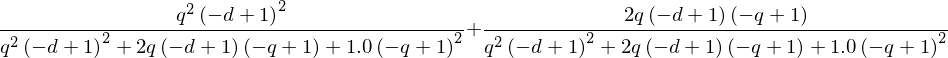

In [147]:
pheno_posterior = genotype_posterior.get_phenotype_probability(inheritance_pattern='AR', sex=FEMALE)
symbolic_carrier_risk = pheno_posterior['carrier'] + pheno_posterior['affected']
symbolic_carrier_risk

In [157]:
residual_risk = symbolic_carrier_risk.subs({
    'q': sqrt(1 / 10000.),
    'd': 0.99
})
from counsyl.product.common.templatetags.counsyl_tags import pretty_one_in
residual_risk, pretty_one_in(float(residual_risk.evalf()))

(0.000201989597020604, u'1 in 5,000')

## Reproductive risk
Similar, but a bit more complicated.

- Perform bayesian update on each patient's genotype prior.
- Simulate meiosis to get an allele distribution the gametes from each parent.
- Fertilize the two allele distributions to get a genotype distribution on the child. ❤️
- Convert genotypes to phenotypes, and look at `affected`.

In [149]:
genotype_posterior.allele_transmission_probability

0    1.0*q*(-d + 1)*(-q + 1)/(q**2*(-d + 1)**2 + 2*...
1    q**2*(-d + 1)**2/(q**2*(-d + 1)**2 + 2*q*(-d +...
dtype: object

In [150]:
gamete_dist = genotype_posterior.allele_transmission_probability
child_genotype_dist = GenotypeProbability(
    get_product_distribution(gamete_dist, gamete_dist)

    # Sum the number of deleterious alleles.
    .transform(sum)
    
    # Map counts to constants ued in computing risk.
    .transform({0: ZERO, 1: ONE, 2: TWO_PLUS}))
child_genotype_dist

0     (1.0*q*(-d + 1)*(-q + 1)/(q**2*(-d + 1)**2 + 2...
1     2*(q**2*(-d + 1)**2/(q**2*(-d + 1)**2 + 2*q*(-...
2+    (q**2*(-d + 1)**2/(q**2*(-d + 1)**2 + 2*q*(-d ...
dtype: object

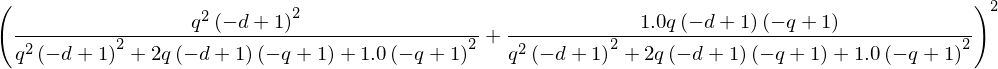

In [151]:
pheno_dist = child_genotype_dist.get_phenotype_probability(inheritance_pattern='AR', sex=FEMALE)
pheno_dist['affected']

In [152]:
pretty_one_in(float(pheno_dist['affected'].subs({
    'q': sqrt(1 / 10000.),
    'd': 0.99
})))

u'&lt; 1 in 1,000,000'

# Sympy Gotchas

Equality is kinda weird.

In [91]:
sin(x) ** 2 + cos(x) ** 2 == 1

False

In [92]:
simplify(sin(x) ** 2 + cos(x) ** 2 - 1) == 0

True

## Return types are weird

Though it usually doesn't matter

In [105]:
type(cos(x).subs({x: pi}))

sympy.core.numbers.NegativeOne

In [135]:
pretty_one_in(residual_risk)

TypeError: Cannot convert 0.000201979396041006 to Decimal

## Wonky in django templates

In [158]:
from django.template.base import Template, Context
template = Template("Let the prevalence be denoted by ${{ prevalence_var }}$.")
template.render(context=Context({'prevalence_var': Symbol('\alpha')}))

ValueError: max() arg is an empty sequence

In [159]:
sympy.Expr.do_not_call_in_templates = True
result = template.render(context=Context({'prevalence_var': Symbol(r'\alpha')}))
del sympy.Expr.do_not_call_in_templates
result

u'Let the prevalence be denoted by $\\alpha$.'

In [3]:
# Trick: display markdown directly in jupyter notebook
from IPython.display import display, Markdown
display(Markdown(r'*some markdown* $\phi$'))

*some markdown* $\phi$